In [61]:
import os
from glob import glob
import cv2
from tqdm.notebook import tqdm

from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.applications import imagenet_utils

from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import hamming, cosine

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pickle

## Data preprocessing

In [62]:
#select desired categories from top
classes = ['Anorak',
 'Blouse',
 'Bomber',
 'Cardigan',
 'Jacket',
 'Parka',
 'Sweater',
 'Tank',
 'Tee']

In [63]:
def mkdir(p):
    if not os.path.exists(p):
        os.mkdir(p)

def link(src, dst):
    if not os.path.exists(dst):
        os.symlink(src, dst)

mkdir('../dataset/modified_new')

In [64]:
images_path = os.path.abspath('../dataset/Img/img')

train_path_to = os.path.abspath('../dataset/modified_new/Training')
valid_path_to = os.path.abspath('../dataset/modified_new/Validation')

mkdir(train_path_to)
mkdir(valid_path_to)

class_images_dict = {}
for c in classes:
    class_images_dict[c] = glob(images_path + '/*{0}/*'.format(c))
class_images_dict.keys()

dict_keys(['Anorak', 'Blouse', 'Bomber', 'Cardigan', 'Jacket', 'Parka', 'Sweater', 'Tank', 'Tee'])

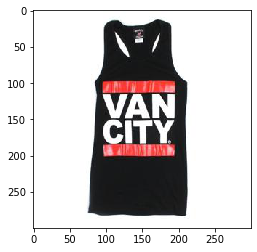

In [65]:
#show random image
plt.imshow(image.img_to_array(image.load_img(np.random.choice(class_images_dict['Tank']))).astype('uint8'))
plt.show()

## Define classes and perform test-train split

In [66]:
new_category_map = {'Anorak':'0','Bomber':'0','Jacket':'0','Parka':'0', #Anorak, bomber, jacket,parka
                    'Cardigan':'1', #Cardigan
                    'Sweater':'2',#sweater
                    'Tank':'3',#Tank
                    'Blouse':'4',#blouse
                    'Tee':'5'#Tee
                   }

In [67]:
total_images = []
for c in class_images_dict.keys():
    cur_class_list = class_images_dict[c]
    temp_array = []
    for idx,img_path in enumerate(cur_class_list[:5000]):
        temp = cur_class_list[idx]
        temp = img_path + '+' + new_category_map[c]
        temp_array.append(temp)
    total_images += temp_array

total_images = shuffle(total_images)

In [68]:
total_images = [item.split('+') for item in total_images]
X_t,y_t = zip(*total_images)

In [69]:
#Peek first 5 pair
print(X_t[:5])
print()
print(y_t[:5])

('/Users/daviesodu/Vizo/git_stuff/sb/dataset/Img/img/Marled_Shawl_Collar_Cardigan/img_00000061.jpg', '/Users/daviesodu/Vizo/git_stuff/sb/dataset/Img/img/Basic_Tank/img_00000046.jpg', '/Users/daviesodu/Vizo/git_stuff/sb/dataset/Img/img/Tassel_Fringe_Knit_Sweater/img_00000043.jpg', '/Users/daviesodu/Vizo/git_stuff/sb/dataset/Img/img/Tasseled_Lace-Up_Sweater/img_00000019.jpg', '/Users/daviesodu/Vizo/git_stuff/sb/dataset/Img/img/Draped_Surplice_Blouse/img_00000084.jpg')

('1', '3', '2', '2', '4')


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size=0.33, random_state=42)

## Create symbolic link for train and val data to enable us use gen.flow_from_directory in the future

In [71]:
set(new_category_map.values())

{'0', '1', '2', '3', '4', '5'}

In [72]:
#Clear symlinks for train and val directories if already exists
def create_class_folders(dataset):
    for i in range(len(set(new_category_map.values()))):
        p = os.path.abspath('../dataset/modified_new/'+dataset+'/'+str(i))
        mkdir(p)
        
create_class_folders('Training')  
create_class_folders('Validation')  

def clear_symlinks(): 
    arr = glob('../dataset/modified_new/Validation/*/*') + glob('../dataset/modified_new/Training/*/*')
    for a in arr:
        os.unlink(a)
    
clear_symlinks()     

assert glob('../dataset/modified_new/Training/*/*')== []
assert glob('../dataset/modified_new/Validation/*/*')== []

def create_symlinks(X, dataset_path):
    for img_path in X:
        img_class=img_path.split('/')[-2].split('_')[-1]
        src = img_path
        dst = dataset_path + '/' + new_category_map[img_class] + '/'+ ''.join(img_path.split('/')[7:])
        if os.path.exists(src):
            link(src, dst)
        
create_symlinks(X_train,train_path_to)
create_symlinks(X_test,valid_path_to)

len(X_test)

10278

## Assert that symlinks were created for train and test data as expected

In [73]:
train_links = glob('../dataset/modified_new/Training/*/*')
val_links = glob('../dataset/modified_new/Validation/*/*')
assert(len(train_links)==len(X_train))
assert(len(val_links)==len(X_test))

#save validation dataset to pickle file.
with open('../dataset/modified_new/catalog/val_paths.pickle', 'wb') as f:
    pickle.dump(val_links, f)

## Preview image

In [74]:
p = X_train[10]
imgg = cv2.imread(p)
imgg.shape

(300, 300, 3)

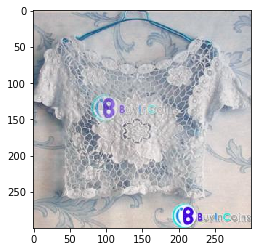

In [75]:
plt.imshow(imgg)

# Create and compile Model

In [76]:
#model params
IMAGE_SIZE = [100, 100]
epochs = 10
batch_size = 128

In [77]:
# add preprocessing layer to the front of VGG
model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [78]:
# don't train existing weights
for layer in model.layers:
    layer.trainable = False

In [79]:
# Optional layers for future additional training

#x = Flatten()(vgg.output)
#x = Dense(4096, activation='relu', )(x)
#x = Dropout(0.5)(x)
#prediction = Dense(6, activation='softmax')(x)

# create a model object
#model = Model(inputs=vgg.input, outputs=prediction)

In [80]:
#specify cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

In [81]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

### Extract feature vector from validation dataset and save for hamming comparison

In [82]:
mkdir('../dataset/modified_new/catalog')

In [83]:
def create_features(dataset_symlinks, pre_model, batch_size,image_dim,distance='hamming'):
 
    x_scratch = []
 
    # loop over the images
    for imagePath in tqdm(dataset_symlinks):
        
        imagePath=os.readlink(imagePath)
        img = image.load_img(imagePath, target_size=(image_dim, image_dim))
        img = image.img_to_array(img)
 
        # preprocess the image by (1) expanding the dimensions and
        # (2) subtracting the mean RGB pixel intensity from the
        # ImageNet dataset
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
 
        # add the image to the batch
        x_scratch.append(img)
 
    x = np.vstack(x_scratch)
    features = pre_model.predict(x, batch_size=batch_size)
    features_flatten = features.reshape((features.shape[0], 3 * 3 * 512))
    
    if distance == 'hamming':
        features_flatten = np.where(features_flatten < 0.5, 0, 1)
        
        with open('../dataset/modified_new/catalog/hamming_train_vectors.pickle', 'wb') as f:
            pickle.dump(features_flatten, f, protocol=pickle.HIGHEST_PROTOCOL)
    elif distance == 'cosine':
        with open('../dataset/modified_new/catalog/cosine_train_vectors.pickle', 'wb') as f:
            pickle.dump(features_flatten, f, protocol=pickle.HIGHEST_PROTOCOL)

In [84]:
create_features(val_links, model, batch_size, IMAGE_SIZE[0], 'hamming')

# Similarity calculation

In [85]:
def simple_inference(model,
                    train_set_vectors,
                    uploaded_image_path,
                    image_size,
                    distance='cosine'):
    '''
    Doing simple inference for single uploaded image.
    
    :param model: CNN model:
    :param session: tf.session, restored session
    :param train_set_vectors: loaded training set vectors
    :param uploaded_image_path: stringm path to uploaded image
    :param image_size: tuple, single image(height, width)
    :param distance: string, type of distance to be used,
                            this parameter is used to choose a way how to prepare vectors
    '''
    
    imagePath=uploaded_image_path
    img = image.load_img(imagePath, target_size=(image_size, image_size))
    img = image.img_to_array(img)

    # preprocess the image by (1) expanding the dimensions and
    # (2) subtracting the mean RGB pixel intensity from the
    # ImageNet dataset
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    
    features = model.predict([img])
    features_flatten = features.reshape(3*3*512)
    
    closest_ids = None
    
    if distance == 'hamming':
        train_set_vectors = np.where(train_set_vectors < 0.5,0,1)
        closest_ids = hamming_distance(train_set_vectors, features_flatten)
        
    elif distance == 'cosine':
        closest_ids = cosine_distance(train_set_vectors, features_flatten)
    
    return closest_ids

def hamming_distance(training_set_vectors, query_vector, top_n=20):
    '''
    Calculates hamming distance between query image and all training set images
    
    :param training_set_vectors: numpy matrix
    :param query_vector: numpy vector
    :param top_n: integer
    '''
    distances = []
    
    for training_vector in training_set_vectors:
        distances.append(hamming(training_vector, query_vector))
    return np.argsort(distances)[:top_n]

def cosine_distance(training_set_vectors, query_vector, top_n=20):
    '''
    Calculates cosine distance between query image and all training set images
    
    :param training_set_vectors: numpy matrix
    :param query_vector: numpy vector
    :param top_n: integer
    '''
    
    distances = []
    
    for training_vector in training_set_vectors:
        distances.append(cosine(training_vector, query_vector[0]))
    return np.argsort(distances)[:top_n]

## Test visual search engine

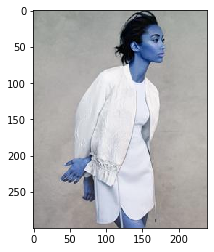

In [86]:
random_image_to_search = val_links[20]
plt.imshow(cv2.imread(random_image_to_search))

In [88]:
#load our catalog of image vectors
with open('../dataset/modified_new/catalog/hamming_train_vectors.pickle', 'rb') as handle:
    images_in_catalog = pickle.load(handle)

In [89]:
search_result = simple_inference(model,
                    images_in_catalog,
                    random_image_to_search,
                    IMAGE_SIZE[0],
                    distance='hamming')
print( 'search complete, indices of best 20 matching images shown below')
print( '                            <============>')
search_result

search complete, indices of best 20 matching images shown below
                            <============>


array([   20,  8712,  9846,  1202,   869,  2870,  9393,  8279,  9989,
        9018,   615,  6636,  9149,  5162,  1565,  8879, 10010,   807,
        2561,  1897])

## Display similar images from catalog

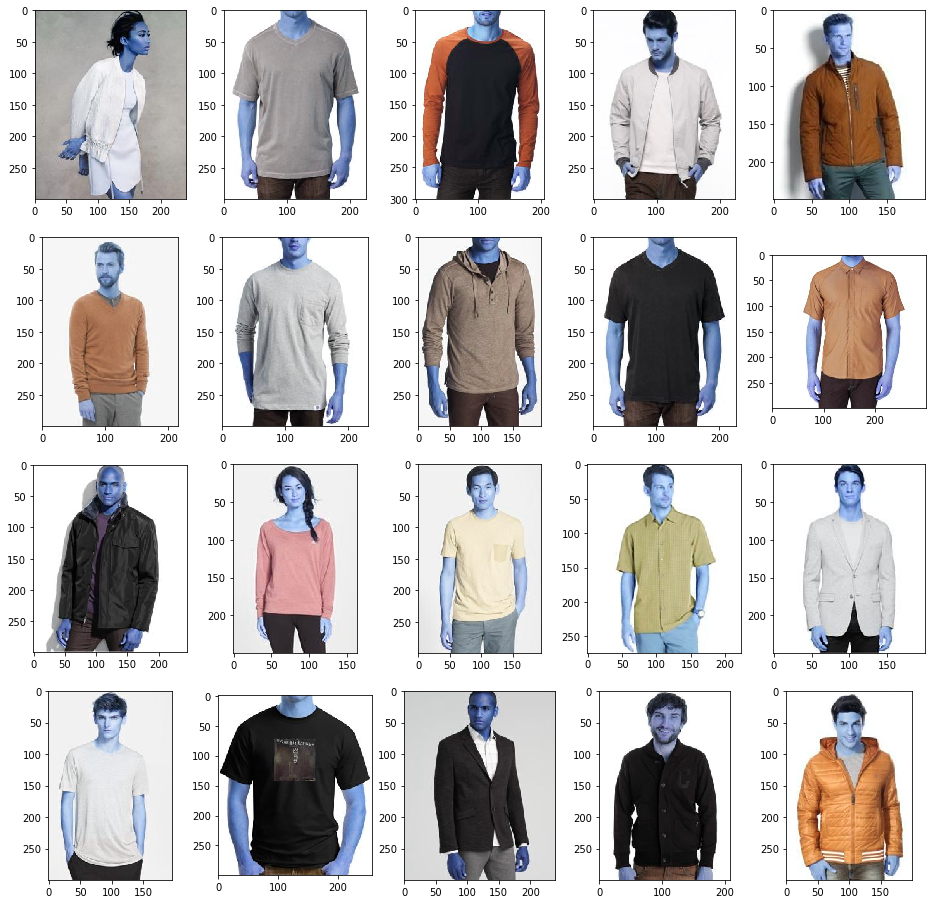

In [90]:
flg = plt.figure(figsize=(16,16))
columns = 5
rows = 4

for i in range(columns*rows):
    try:
        img_path = val_links[search_result[i]]
        img = cv2.imread(img_path)
        flg.add_subplot(rows, columns, i+1)
        plt.imshow(img)
    except:
        pass
plt.show()